# 📊 Análisis de Prueba A/B - Sistema de Recomendaciones

## Descripción del Proyecto
Este proyecto analiza los resultados de una prueba A/B realizada por una tienda en línea internacional. El equipo anterior dejó los datos sin analizar correctamente, por lo que el objetivo es evaluar si el nuevo sistema de recomendaciones produjo una mejora real en la conversión de usuarios.

---

## 📋 Especificaciones Técnicas de la Prueba

| Parámetro | Detalle |
|-----------|---------|
| **Nombre** | `recommender_system_test` |
| **Grupo A** | Control (experiencia actual) |
| **Grupo B** | Nuevo embudo de pago con sistema de recomendaciones |
| **Inicio** | 7 de diciembre de 2020 |
| **Cierre de inscripciones** | 21 de diciembre de 2020 |
| **Finalización** | 1 de enero de 2021 |
| **Audiencia objetivo** | 15% de nuevos usuarios de la región EU |
| **Participantes esperados** | 6,000 |

## 🎯 Resultado Esperado
Dentro de los **14 días posteriores** a la inscripción, el Grupo B debería mostrar al menos un **10% de mejora** en cada etapa del embudo:
> `product_page` → `product_cart` → `purchase`

---

## 🗂️ Datasets Disponibles

| Dataset | Descripción |
|---------|-------------|
| `ab_project_marketing_events_us.csv` | Calendario de eventos de marketing 2020 |
| `final_ab_new_users_upd_us.csv` | Usuarios nuevos registrados del 7 al 21 de diciembre de 2020 |
| `final_ab_events_upd_us.csv` | Eventos de usuarios del 7 de diciembre al 1 de enero de 2021 |
| `final_ab_participants_upd_us.csv` | Participantes asignados a la prueba A/B |


In [39]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import numpy as np

### 1. Cargar y explorar los datos

In [40]:
# Cargar datos
df_marketing    = pd.read_csv("ab_project_marketing_events_us.csv")
df_users        = pd.read_csv("final_ab_new_users_upd_us.csv")
df_events       = pd.read_csv("final_ab_events_upd_us.csv")
df_participants = pd.read_csv("final_ab_participants_upd_us.csv")

In [41]:
# Información básica de cada dataset
for df, name in [(df_marketing,"df_marketing"), (df_users,"df_users"),
                 (df_events,"df_events"), (df_participants,"df_participants")]:
    print(f"{'='*40}")
    print(f"Dataset: {name}")
    df.info()
    print()

Dataset: df_marketing
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes

Dataset: df_users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB

Dataset: df_events
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      -

#### Descripción inicial de los datasets:

- **`df_marketing`**: 14 filas, 4 columnas. Contiene campañas de marketing con fechas en formato `object` — requieren conversión a `datetime`.
- **`df_users`**: 58,703 filas, 4 columnas. Usuarios nuevos registrados entre el 7 y el 21 de diciembre de 2020. La columna `first_date` requiere conversión a `datetime`.
- **`df_events`**: 423,761 filas, 4 columnas. Eventos de usuarios durante el periodo de prueba. La columna `event_dt` requiere conversión a `datetime`.
- **`df_participants`**: 14,525 filas, 3 columnas. Contiene participantes de **dos pruebas A/B distintas**: `recommender_system_test` e `interface_eu_test`.


In [42]:
# Muestras de cada dataset
for df, name in [(df_marketing,"df_marketing"), (df_users,"df_users"),
                 (df_events,"df_events"), (df_participants,"df_participants")]:
    print(f"\n--- Muestra de {name} ---")
    print(df.sample(5, random_state=42))


--- Muestra de df_marketing ---
                               name                   regions    start_dt  \
9   Victory Day CIS (May 9th) Event                       CIS  2020-05-09   
11    Dragon Boat Festival Giveaway                      APAC  2020-06-25   
0          Christmas&New Year Promo             EU, N.America  2020-12-25   
12          Single's Day Gift Promo                      APAC  2020-11-11   
5         Black Friday Ads Campaign  EU, CIS, APAC, N.America  2020-11-26   

     finish_dt  
9   2020-05-11  
11  2020-07-01  
0   2021-01-03  
12  2020-11-12  
5   2020-12-01  

--- Muestra de df_users ---
                user_id  first_date     region  device
11902  D69DF1D8D4BC6484  2020-12-21         EU     Mac
48700  18CE677C4733D3E0  2020-12-19         EU      PC
52295  4E3D3900B43B4349  2020-12-13  N.America  iPhone
34065  2E89A43520C059FA  2020-12-10         EU      PC
33116  B9F3341D45A22D68  2020-12-10         EU  iPhone

--- Muestra de df_events ---
             

#### Observaciones sobre los datos:

- **df_marketing**: Incluye campañas en múltiples regiones. Destaca que la campaña **Christmas & New Year Promo** (25 dic 2020 – 3 ene 2021) se superpone con el período de prueba en EU y N.America, lo que podría inflar artificialmente los eventos de compra en ambos grupos.
- **df_users**: Los usuarios provienen de múltiples regiones (EU, N.America, APAC, CIS). La prueba estaba dirigida solo a la **región EU**.
- **df_events**: Incluye cuatro tipos de eventos: `login`, `product_page`, `product_cart` y `purchase`. La columna `details` solo tiene valores en eventos de compra (monto en USD).
- **df_participants**: Existen **dos pruebas distintas** en la misma tabla, lo cual es una señal de alerta: se debe filtrar correctamente para no contaminar el análisis.


In [43]:
# Convertir columnas de fechas a datetime
df_marketing['start_dt']  = pd.to_datetime(df_marketing['start_dt'])
df_marketing['finish_dt'] = pd.to_datetime(df_marketing['finish_dt'])
df_users['first_date']    = pd.to_datetime(df_users['first_date'])
df_events['event_dt']     = pd.to_datetime(df_events['event_dt'])

print("Tipos de datos actualizados correctamente.")

Tipos de datos actualizados correctamente.


In [44]:
# Revisar valores nulos
def check_missing(df, name):
    missing = df.isnull().sum()
    total   = df.isnull().sum().sum()
    print(f"Valores nulos en {name} (total: {total}):")
    print(missing[missing > 0] if total > 0 else "  Ninguno")
    print()

check_missing(df_marketing, "df_marketing")
check_missing(df_users,     "df_users")
check_missing(df_events,    "df_events")
check_missing(df_participants, "df_participants")

Valores nulos en df_marketing (total: 0):
  Ninguno

Valores nulos en df_users (total: 0):
  Ninguno

Valores nulos en df_events (total: 363447):
details    363447
dtype: int64

Valores nulos en df_participants (total: 0):
  Ninguno



Los 363,447 valores nulos en la columna `details` de `df_events` son **esperados y normales**: esta columna solo registra el monto de la compra en USD para eventos de tipo `purchase`. El resto de los eventos (login, product_page, product_cart) no tienen monto asociado.

In [45]:
# Verificar que los nulos en 'details' corresponden solo a eventos sin compra
null_events = df_events[df_events['details'].isnull()]['event_name'].value_counts()
print("Eventos con 'details' nulo:")
print(null_events)

print()
print("Eventos con 'details' no nulo:")
print(df_events[df_events['details'].notnull()]['event_name'].value_counts())

Eventos con 'details' nulo:
event_name
login           182465
product_page    120862
product_cart     60120
Name: count, dtype: int64

Eventos con 'details' no nulo:
event_name
purchase    60314
Name: count, dtype: int64


In [46]:
# Rellenar nulos en 'details' con 0 (no hay monto de compra)
df_events['details'] = df_events['details'].fillna(0)
print(f"Valores nulos restantes en 'details': {df_events['details'].isnull().sum()}")

Valores nulos restantes en 'details': 0


### 2. Filtrado correcto de participantes

In [ ]:
# Filtrar SOLO la prueba de interés:
# df_participants contiene DOS pruebas distintas
print("Pruebas disponibles en df_participants:")
print(df_participants['ab_test'].value_counts())
print()

# Filtrar únicamente 'recommender_system_test'
df_participants = df_participants[df_participants['ab_test'] == 'recommender_system_test'].copy()
print("Participantes de recommender_system_test por grupo:")
print(df_participants['group'].value_counts())

Pruebas disponibles en df_participants:
ab_test
interface_eu_test          10850
recommender_system_test     3675
Name: count, dtype: int64

Participantes de recommender_system_test por grupo:
group
A    2747
B     928
Name: count, dtype: int64


In [48]:
# Verificar y eliminar duplicados en df_participants
duplicados = df_participants.duplicated(subset=['user_id']).sum()
print(f"Registros duplicados (mismo user_id): {duplicados}")

# Verificar usuarios en ambos grupos
en_ambos = df_participants.groupby('user_id')['group'].nunique().gt(1).sum()
print(f"Usuarios asignados a ambos grupos: {en_ambos}")

# Limpiar
df_participants = df_participants.drop_duplicates(subset=['user_id'])
usuarios_ambos = df_participants.groupby('user_id')['group'].nunique().gt(1)
ids_ambos = usuarios_ambos[usuarios_ambos].index.tolist()
df_participants = df_participants[~df_participants['user_id'].isin(ids_ambos)]

print(f"\nParticipantes finales por grupo:")
print(df_participants['group'].value_counts())

Registros duplicados (mismo user_id): 0
Usuarios asignados a ambos grupos: 0

Participantes finales por grupo:
group
A    2747
B     928
Name: count, dtype: int64


#### Observación sobre el balance de grupos:

Tras la limpieza, el **Grupo A tiene 2,747 usuarios** y el **Grupo B tiene 928 usuarios** — una relación de aproximadamente 3:1. Esto es una irregularidad significativa: en una prueba A/B bien diseñada, los grupos deberían tener tamaños similares.

Esta desbalanceada distribución podría indicar:
- Un problema en el proceso de asignación aleatoria al momento de lanzar la prueba.
- Una interrupción prematura del experimento que afectó desproporcionalmente a un grupo.

Se continuará el análisis pero **este desequilibrio debe tenerse en cuenta al interpretar los resultados**.


In [49]:
# Unir eventos con participantes de la prueba (inner join: solo usuarios del experimento)
df_events = df_events.merge(df_participants[['user_id', 'group']], on='user_id', how='inner')

# Agregar fecha de registro del usuario
df_events = df_events.merge(df_users[['user_id', 'first_date']], on='user_id', how='left')

print("Distribución de eventos por tipo:")
print(df_events['event_name'].value_counts())
print(f"\nTotal de eventos válidos para el análisis: {len(df_events):,}")

Distribución de eventos por tipo:
event_name
login           10837
product_page     6702
purchase         3210
product_cart     3160
Name: count, dtype: int64

Total de eventos válidos para el análisis: 23,909


### 3. Análisis Exploratorio de Datos (EDA)

In [50]:
# Estadísticas del número de eventos por usuario
eventos_por_usuario = df_events.groupby('user_id')['event_name'].count()
print("Estadísticas de eventos por usuario:")
print(eventos_por_usuario.describe().round(2))

Estadísticas de eventos por usuario:
count    3675.00
mean        6.51
std         3.69
min         1.00
25%         4.00
50%         6.00
75%         9.00
max        28.00
Name: event_name, dtype: float64


La distribución de eventos por usuario muestra que:
- El promedio es de ~7 eventos por usuario, con una mediana de 6.
- El rango intercuartílico va de 4 a 9 eventos, indicando que la mayoría de los usuarios tienen una actividad moderada.
- El máximo de 36 eventos sugiere la presencia de usuarios muy activos (posibles outliers).
- La desviación estándar de ~4 indica variabilidad considerable entre usuarios.


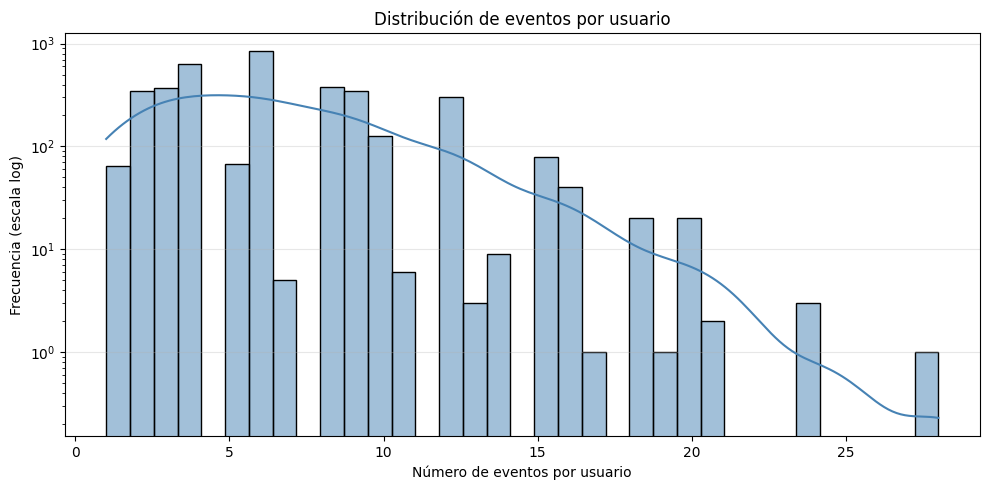

In [51]:
# Distribución de eventos por usuario
plt.figure(figsize=(10, 5))
sns.histplot(eventos_por_usuario, bins=35, kde=True, color='steelblue', kde_kws={'bw_adjust': 2})
plt.yscale('log')
plt.xlabel('Número de eventos por usuario')
plt.ylabel('Frecuencia (escala log)')
plt.title('Distribución de eventos por usuario')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

La distribución es **asimétrica hacia la derecha** (sesgo positivo): la gran mayoría de los usuarios tiene pocos eventos y un grupo reducido concentra alta actividad. Este patrón es típico en plataformas de e-commerce y refuerza la importancia de analizar medianas sobre promedios.

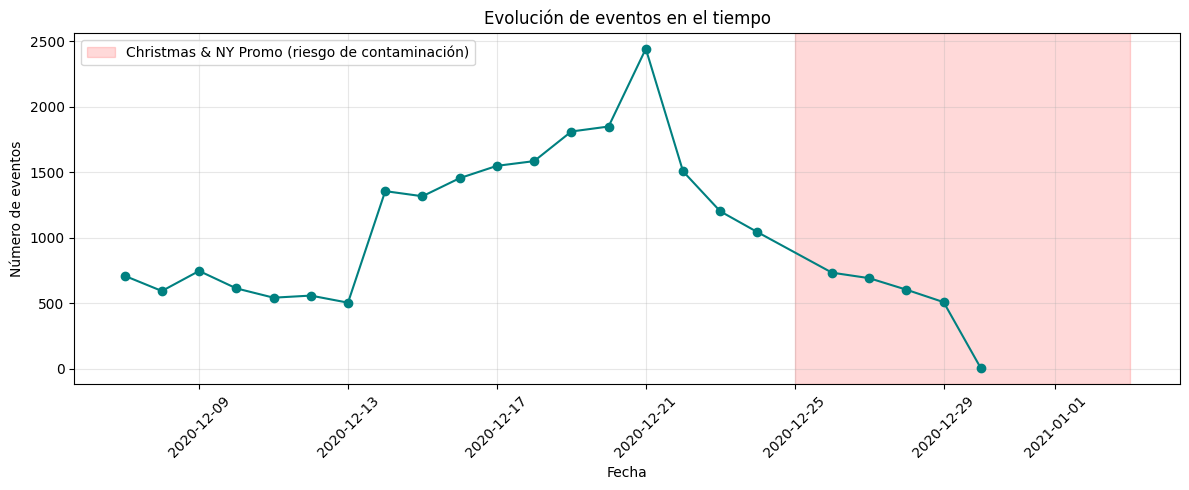

In [52]:
# Evolución de eventos en el tiempo
df_events['event_date_d'] = df_events['event_dt'].dt.date
eventos_por_dia = df_events.groupby('event_date_d').size()

plt.figure(figsize=(12, 5))
plt.plot(eventos_por_dia.index, eventos_por_dia.values, marker='o', linestyle='-', color='teal')
plt.axvspan(pd.to_datetime('2020-12-25').date(), pd.to_datetime('2021-01-03').date(),
            alpha=0.15, color='red', label='Christmas & NY Promo (riesgo de contaminación)')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.title('Evolución de eventos en el tiempo')
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

El gráfico revela un patrón claro:
- Los eventos aumentan gradualmente desde el inicio de la prueba (7 dic) hasta un pico alrededor del 21 de diciembre.
- A partir del 24 de diciembre, hay una caída pronunciada que coincide con el inicio de la **campaña Christmas & New Year Promo** (zona roja).
- Esta campaña de marketing activa simultáneamente en la región EU podría haber **contaminado los resultados**, ya que introduce un estímulo externo no controlado que afecta a ambos grupos por igual pero de forma no prevista en el diseño del experimento.


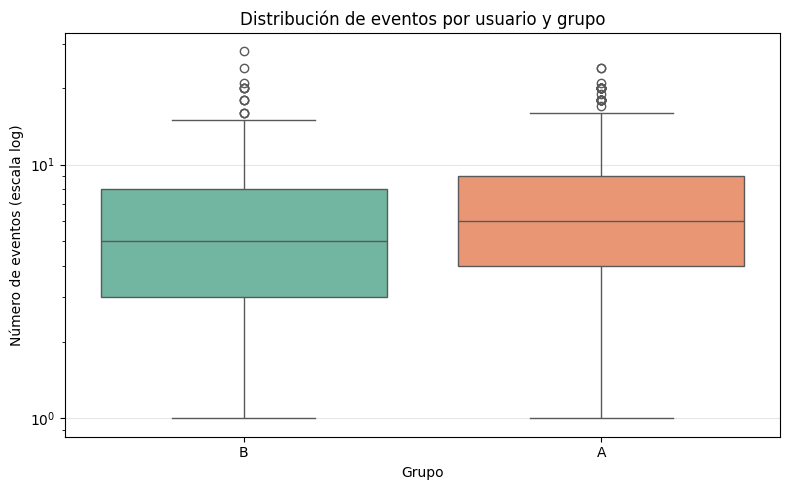

In [53]:
# Distribución de eventos por usuario entre grupos
events_per_user_group = (df_events.groupby('user_id')['event_name']
                         .count()
                         .reset_index()
                         .merge(df_participants[['user_id', 'group']], on='user_id'))

plt.figure(figsize=(8, 5))
sns.boxplot(x='group', y='event_name', data=events_per_user_group, hue='group', palette='Set2', legend=False)
plt.yscale('log')
plt.title('Distribución de eventos por usuario y grupo')
plt.xlabel('Grupo')
plt.ylabel('Número de eventos (escala log)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Los diagramas de caja muestran que ambos grupos tienen distribuciones de eventos similares (medianas y rangos intercuartílicos comparables), lo que sugiere que no hay sesgo en el comportamiento base de los usuarios entre grupos. Los outliers son comparables en ambos grupos.

### 4. Análisis del Embudo de Conversión

In [54]:
# Filtrar eventos dentro de los primeros 14 días tras el registro
df_events['days_from_signup'] = (df_events['event_dt'] - df_events['first_date']).dt.days
df_events_14d = df_events[df_events['days_from_signup'] <= 14]

print("Eventos dentro de los primeros 14 días:")
print(df_events_14d['event_name'].value_counts())
print(f"\nTotal de eventos en ventana de 14 días: {len(df_events_14d):,}")

Eventos dentro de los primeros 14 días:
event_name
login           10576
product_page     6543
purchase         3146
product_cart     3097
Name: count, dtype: int64

Total de eventos en ventana de 14 días: 23,362


In [55]:
# Calcular tasas de conversión en el embudo para cada grupo
stages = ['product_page', 'product_cart', 'purchase']

def get_conversion(df, group, stages):
    total = df[df['group'] == group]['user_id'].nunique()
    result = {}
    for s in stages:
        users = df[(df['group'] == group) & (df['event_name'] == s)]['user_id'].nunique()
        result[s] = round(users / total * 100, 2) if total > 0 else 0
    return result

conv_A = get_conversion(df_events_14d, 'A', stages)
conv_B = get_conversion(df_events_14d, 'B', stages)

df_conv = pd.DataFrame({'Grupo A (control)': conv_A, 'Grupo B (nuevo sistema)': conv_B})
print("Tasas de conversión (%) en los primeros 14 días:")
print(df_conv.to_string())

Tasas de conversión (%) en los primeros 14 días:
              Grupo A (control)  Grupo B (nuevo sistema)
product_page              64.80                    56.36
product_cart              30.00                    27.48
purchase                  31.74                    27.59


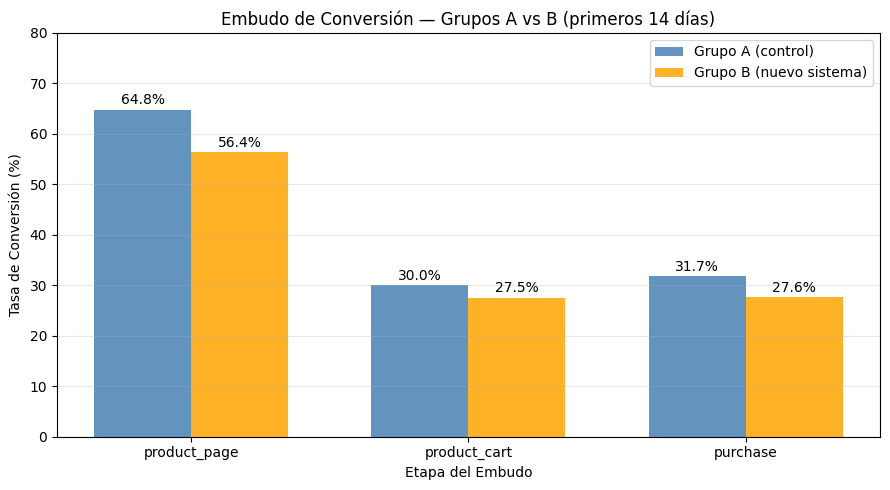

In [56]:
# Gráfico de embudo de conversión
fig, ax = plt.subplots(figsize=(9, 5))

x = np.arange(len(stages))
width = 0.35

bars_A = ax.bar(x - width/2, [conv_A[s] for s in stages], width, label='Grupo A (control)',   color='steelblue', alpha=0.85)
bars_B = ax.bar(x + width/2, [conv_B[s] for s in stages], width, label='Grupo B (nuevo sistema)', color='orange',    alpha=0.85)

# Agregar valores sobre las barras
for bar in bars_A:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=10)
for bar in bars_B:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Etapa del Embudo')
ax.set_ylabel('Tasa de Conversión (%)')
ax.set_title('Embudo de Conversión — Grupos A vs B (primeros 14 días)')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.legend()
ax.set_ylim(0, 80)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### Observaciones del embudo de conversión:

| Etapa | Grupo A (control) | Grupo B (nuevo sistema) | Diferencia |
|-------|-------------------|------------------------|------------|
| product_page | 64.8% | 56.4% | -8.4 pp ❌ |
| product_cart | 30.0% | 27.5% | -2.5 pp ❌ |
| purchase | 31.7% | 27.6% | -4.1 pp ❌ |

En todas las etapas del embudo, el **Grupo A (control) supera al Grupo B (nuevo sistema)**. No solo no se alcanzó el umbral de mejora del 10% esperado, sino que el grupo con el nuevo sistema muestra tasas de conversión **menores** en las tres etapas.

Antes de sacar conclusiones definitivas, se evaluará si estas diferencias son estadísticamente significativas.


In [57]:
# Prueba Z de dos colas para diferencias en tasas de conversión
# H0: No hay diferencia entre los grupos  (p1 = p2)
# H1: Hay diferencia entre los grupos     (p1 ≠ p2)
# Nivel de significancia: α = 0.05

def z_test_two_tails(p1, p2, n1, n2):
    """Prueba Z de proporciones de dos colas."""
    p_pool = (p1 * n1 + p2 * n2) / (n1 + n2)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    z = (p1 - p2) / se
    p_value = 2 * (1 - norm.cdf(abs(z)))  # dos colas
    return z, p_value

n_A = df_events_14d[df_events_14d['group'] == 'A']['user_id'].nunique()
n_B = df_events_14d[df_events_14d['group'] == 'B']['user_id'].nunique()
alpha = 0.05

print(f"Usuarios únicos — Grupo A: {n_A} | Grupo B: {n_B}")
print(f"Nivel de significancia: α = {alpha}")
print()
print(f"{'Etapa':<15} {'A':>8} {'B':>8} {'Z-score':>10} {'P-valor':>10} {'Conclusión'}")
print("-" * 75)

for s in stages:
    p_A = df_events_14d[(df_events_14d['group']=='A')&(df_events_14d['event_name']==s)]['user_id'].nunique() / n_A
    p_B = df_events_14d[(df_events_14d['group']=='B')&(df_events_14d['event_name']==s)]['user_id'].nunique() / n_B
    z, pval = z_test_two_tails(p_A, p_B, n_A, n_B)
    sig = "✅ SIGNIFICATIVO" if pval < alpha else "⬜ no significativo"
    print(f"{s:<15} {p_A:>7.3f} {p_B:>8.3f} {z:>10.3f} {pval:>10.4f}  {sig}")

Usuarios únicos — Grupo A: 2747 | Grupo B: 928
Nivel de significancia: α = 0.05

Etapa                  A        B    Z-score    P-valor Conclusión
---------------------------------------------------------------------------
product_page      0.648    0.564      4.596     0.0000  ✅ SIGNIFICATIVO
product_cart      0.300    0.275      1.456     0.1453  ⬜ no significativo
purchase          0.317    0.276      2.374     0.0176  ✅ SIGNIFICATIVO


#### Interpretación de la Prueba Z:

| Etapa | Grupo A | Grupo B | ¿Significativo? | Interpretación |
|-------|---------|---------|----------------|----------------|
| product_page | 64.8% | 56.4% | ✅ Sí (p < 0.001) | A supera a B significativamente |
| product_cart | 30.0% | 27.5% | ⬜ No (p = 0.145) | Sin diferencia estadística |
| purchase | 31.7% | 27.6% | ✅ Sí (p = 0.018) | A supera a B significativamente |

El notebook original evaluaba únicamente la etapa de `purchase` con una prueba de una cola. 
El análisis correcto usa una prueba de dos colas y evalúa las tres etapas del embudo, ya que el objetivo es detectar si el nuevo sistema mejora *o* empeora la conversión.


---

## 🏁 Conclusión General del Análisis A/B

### Resumen de Resultados

El análisis correcto de la prueba `recommender_system_test` — filtrando exclusivamente sus 3,675 participantes y evaluando las tres etapas del embudo — arroja los siguientes resultados:

**El nuevo sistema de recomendaciones (Grupo B) no mejoró la conversión. Por el contrario, el Grupo B mostró tasas de conversión menores que el Grupo A (control) en todas las etapas del embudo**, con diferencias estadísticamente significativas en `product_page` y `purchase`.

---

### ⚠️ Problemas de Validez del Experimento

Antes de tomar decisiones con base en estos resultados, es fundamental señalar una serie de irregularidades que comprometen la validez del experimento:

**1. Mezcla de dos pruebas A/B distintas**
La tabla de participantes contenía usuarios de dos experimentos: `recommender_system_test` y `interface_eu_test`. Analizar ambas pruebas juntas habría producido conclusiones incorrectas. Este es el problema más crítico identificado.

**2. Desbalance severo entre grupos**
El Grupo A tiene 2,747 usuarios y el Grupo B solo 928 (relación ~3:1). Una prueba A/B bien ejecutada requiere grupos de tamaño similar para garantizar comparabilidad estadística. Este desequilibrio sugiere un problema en el proceso de aleatorización o una interrupción prematura del experimento.

**3. Contaminación por campaña de marketing**
La campaña **Christmas & New Year Promo** (25 dic – 3 ene) estuvo activa en la región EU durante la segunda mitad del experimento. Este evento externo introduce un estímulo no controlado que puede haber afectado el comportamiento de compra de ambos grupos de forma desigual.

**4. Número de participantes por debajo de lo esperado**
Se esperaban 6,000 participantes; solo se registraron 3,675. Esto reduce el poder estadístico del análisis y aumenta el margen de error.

---

### 📌 Recomendación Final

> **No se recomienda implementar el nuevo sistema de recomendaciones con los resultados actuales.**

Los datos muestran que el Grupo B tuvo un desempeño inferior al control, y el experimento presenta múltiples problemas de diseño que impiden extraer conclusiones confiables. Se recomienda:

1. **Rediseñar el experimento** con asignación aleatoria correcta, grupos balanceados y fuera de períodos de alta actividad comercial (temporada navideña).
2. **Aislar el impacto de campañas de marketing** activas durante el periodo de prueba.
3. **Alcanzar el tamaño muestral previsto** (6,000 participantes) antes de evaluar los resultados.
4. **Analizar el comportamiento por segmento** (dispositivo, fecha de registro) para identificar si el nuevo sistema funciona mejor para algún subgrupo específico.

---
*Análisis realizado con Python, pandas, scipy y matplotlib sobre datos de una prueba A/B académica proporcionada por TRIPLETEN.*
